# Comparison of library strategies

We aim at comparing how different is the variant calling outcome depending on the library strategy employed.
For this purpose we will use samples obtained from ENA (last queried 09/10/2021, n=48,844 samples) sequenced with Illumina technology using three library strategies: WGS, WGA and targeted-capture.
The SARS-CoV-2 ENA dataset is imperfect for this purpose as we don't have the same samples sequenced with different strategies.
Furthermore, we expect a high heterogeneity between sequencing centers across the globe using the same library strategy.

We aim to look at two factors: 1) mutations and 2) coverage.

Regarding 1) we are interested in understanding:
* Overall number of mutations per sample
* Unique mutations for each technology
* Focused geographical and temporal analysis to minimise expected variability in SARS-CoV-2

Regarding 2) we are interested in understanding:
* How depth of coverage differs between technologies
* How breadth of coverage differs between technologies
* Are there any blind spots of a particular technology?

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import upsetplot
sns.set_context("paper")
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [2]:
blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
green = sns.color_palette("colorblind")[2]
red = sns.color_palette("colorblind")[3]
brown = sns.color_palette("colorblind")[5]
grey = sns.color_palette("colorblind")[7]
lightblue = sns.color_palette("colorblind")[-1]

In [3]:
colors_library_strategy = {
    "RNA-Seq": blue,
    "Targeted-Capture": orange,
    "WGS": green,
    "WGA": grey
}

## Data loading

In [4]:
data_folder = '/data'
local_data_folder = './data'
figures_folder = './figures'

In [5]:
samples = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'))
ena_num_samples = samples[samples.status == 'FINISHED'].shape[0]
ena_num_samples

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (77) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


84125

In [6]:
variants = pd.read_csv(os.path.join(data_folder, 'variant_observation.csv.gz'))
variants.head()

,sample,variant_id,chromosome,position,reference,alternate,quality,filter,dp,ac,...,variant_type,length,reference_amino_acid,alternate_amino_acid,position_amino_acid,cons_hmm_sars_cov_2,cons_hmm_sarbecovirus,cons_hmm_vertebrate_cov,pfam_name,pfam_description
0,ERR5063089,445:T>C,MN908947.3,445,T,C,480,NaN,14,14,...,SNV,0,NaN,NaN,NaN,-0.85561,-0.85561,-0.72927,NSP1_bCoV,"Non-structural protein NSP1, betacoronavirus"
1,ERR5063089,6286:C>T,MN908947.3,6286,C,T,1450,NaN,41,41,...,SNV,0,NaN,NaN,NaN,0.00000,0.00000,0.00000,NSP3_NAR_bCoV,"Non-structural protein NSP3, nucleic acid-bind..."
2,ERR5063089,11396:C>T,MN908947.3,11396,C,T,456,NaN,14,14,...,SNV,0,L,F,3711.0,0.00000,0.00000,0.00000,CoV_NSP6,Coronavirus replicase NSP6
3,ERR5063089,21255:G>C,MN908947.3,21255,G,C,653,NaN,19,19,...,SNV,0,R,P,6997.0,-0.85561,-0.85561,0.00000,NSP16_CoV-like,"Non-structural protein NSP16, coronavirus-like"
4,ERR5063089,21614:C>T,MN908947.3,21614,C,T,1060,NaN,32,32,...,SNV,0,L,F,18.0,0.00000,0.00000,0.00000,NaN,NaN


### Data filtering criteria

We exclude samples from other strategy than WGA, WGS or targeted-capture; in particular due to historical reasons we have in our table RNA-Seq samples. Furthermore, samples that failed to be processed by the pipeline or that were excluded due to quality criteria.

In [7]:
samples.status.value_counts()

FINISHED             84125
FAILED_PROCESSING     8102
EXCLUDED               327
FAILED_DOWNLOAD          1
Name: status, dtype: int64

In [8]:
samples.status.value_counts()

FINISHED             84125
FAILED_PROCESSING     8102
EXCLUDED               327
FAILED_DOWNLOAD          1
Name: status, dtype: int64

In [9]:
samples = samples[samples.status == "FINISHED"]

In [10]:
variants.shape

(2259759, 34)

In [11]:
variants = variants[variants["sample"].isin(samples.run_accession)]
variants.shape

(2259582, 34)

## Use of library strategies through time

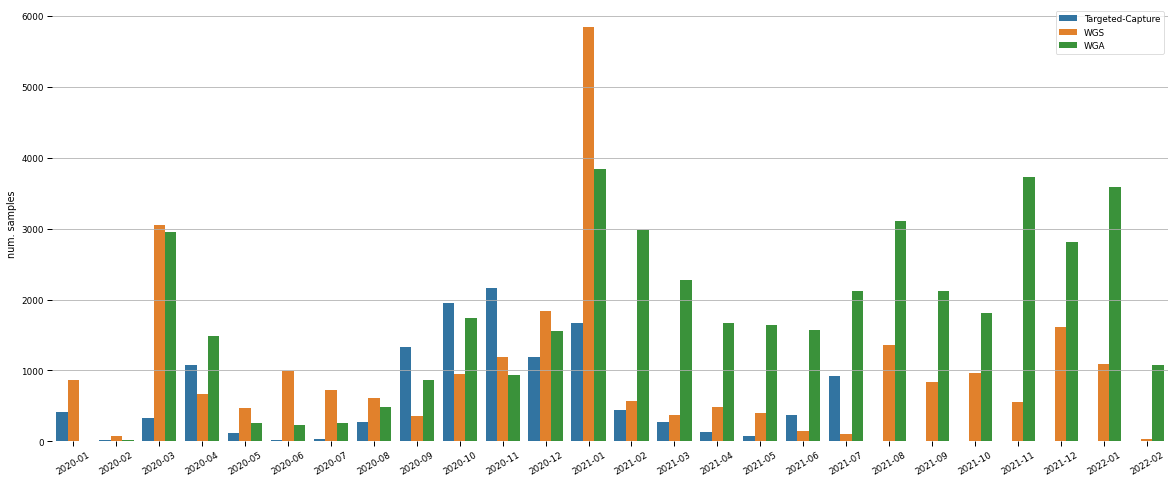

In [12]:
samples["month"] = pd.to_datetime(samples.collection_date, format='%Y-%m-%d', errors='coerce').dt.to_period('m')
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
splot = sns.barplot(data=samples[["library_strategy", "run_accession", "month"]].groupby(["month", "library_strategy"]).count().reset_index(), 
            y="run_accession", x="month", hue='library_strategy')
plt.xticks(rotation=30)
ax.legend(loc='upper right')
splot.set(xlabel=None, ylabel=None)
sns.despine(bottom=True, left=True)
plt.ylabel("num. samples")
plt.grid(axis="y")
fig.savefig(os.path.join(figures_folder, "figure_00_distribution_samples_through_time_by_library_strategy.jpg"), dpi=200)

## Number of mutations per sample

We found an outlier WGA sample having 162 mutations, the next sample with more mutation has less than 60 mutations.
We will exclude this sample from further analysis.

We normalise the number of samples by the total number of samples.

We observed three peaks in number of mutations at just below 10 mutations, just below 20 mutations and just below 40 mutations. 
The third peak is observed for the three library strategies. The first and and second peaks show more variability.
The library strategy more different from the others in terms of number of mutations is the targeted capture, which would make sense if the targeted region is very different.

In [13]:
variants_per_sample = variants[["sample", "variant_id"]].groupby("sample").count().reset_index()
variants_per_sample = pd.merge(variants_per_sample, samples[["run_accession", "library_strategy"]], left_on="sample", right_on="run_accession")
del variants_per_sample["run_accession"]
variants_per_sample.head()

,sample,variant_id,library_strategy
0,DRR287659,1,WGS
1,DRR287660,1,WGS
2,DRR287661,1,WGS
3,DRR287662,1,WGS
4,DRR287663,3,WGS


In [14]:
num_samples_per_variant_count = variants_per_sample.groupby(["library_strategy", "variant_id"]).count().reset_index()
num_samples_per_variant_count.head()

,library_strategy,variant_id,sample
0,Targeted-Capture,1,151
1,Targeted-Capture,2,163
2,Targeted-Capture,3,189
3,Targeted-Capture,4,261
4,Targeted-Capture,5,276


In [15]:
count_samples_by_library_strategy = samples.library_strategy.value_counts().reset_index().rename(
    columns={"index": "library_strategy", "library_strategy": "total_samples"})
count_samples_by_library_strategy

,library_strategy,total_samples
0,WGA,45125
1,WGS,26236
2,Targeted-Capture,12764


In [16]:
num_samples_per_variant_count = pd.merge(num_samples_per_variant_count, count_samples_by_library_strategy, on="library_strategy")
num_samples_per_variant_count["sample_normalised"] = num_samples_per_variant_count["sample"] / num_samples_per_variant_count["total_samples"]
num_samples_per_variant_count.head()

,library_strategy,variant_id,sample,total_samples,sample_normalised
0,Targeted-Capture,1,151,12764,0.011830
1,Targeted-Capture,2,163,12764,0.012770
2,Targeted-Capture,3,189,12764,0.014807
3,Targeted-Capture,4,261,12764,0.020448
4,Targeted-Capture,5,276,12764,0.021623


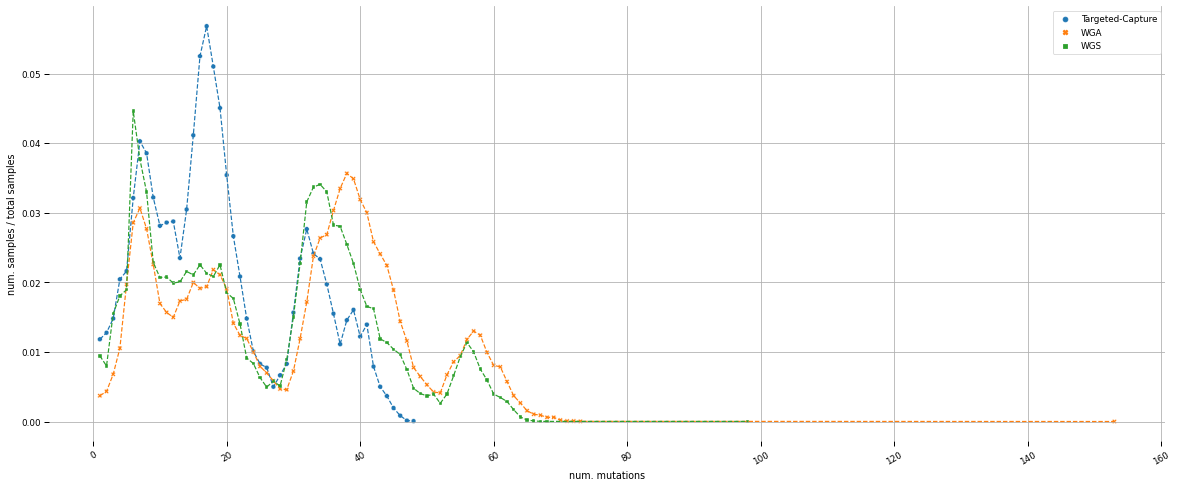

In [17]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=num_samples_per_variant_count, x="variant_id", y="sample_normalised", hue="library_strategy", legend=False, linestyle="--")
sns.scatterplot(data=num_samples_per_variant_count, x="variant_id", y="sample_normalised", hue="library_strategy", style="library_strategy", legend=True)
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("num. mutations")
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_01_mutations_per_sample_distribution.png"))

In [18]:
num_samples_per_variant_count[num_samples_per_variant_count.variant_id > 100]

,library_strategy,variant_id,sample,total_samples,sample_normalised
121,WGA,153,1,45125,0.000022


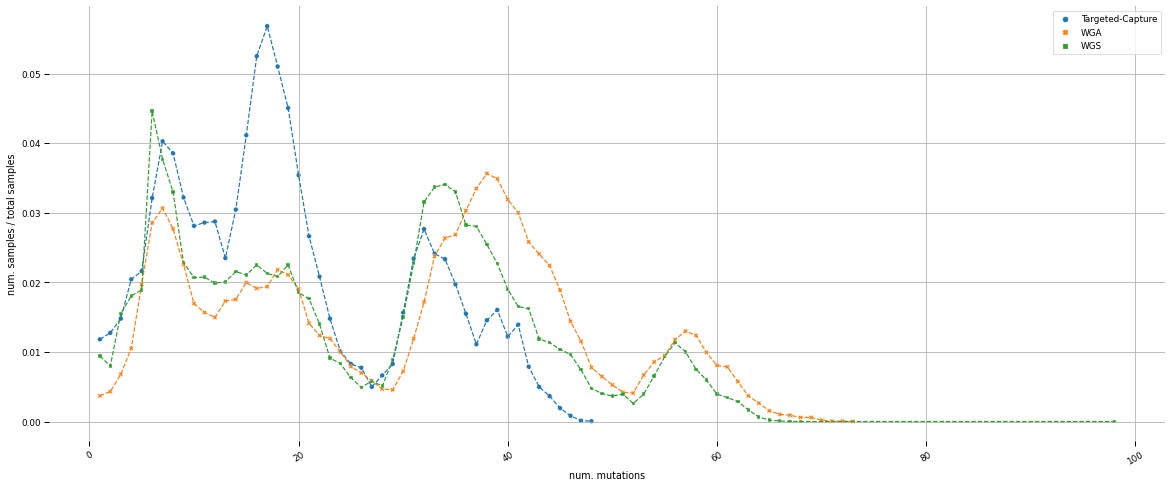

In [19]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=num_samples_per_variant_count[num_samples_per_variant_count.variant_id < 100], 
             x="variant_id", y="sample_normalised", hue="library_strategy", legend=False, linestyle="--")
sns.scatterplot(data=num_samples_per_variant_count[num_samples_per_variant_count.variant_id < 100], 
                x="variant_id", y="sample_normalised", hue="library_strategy", style="library_strategy", legend=True)
plt.xticks(rotation=30)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("num. mutations")
plt.legend(title=None)
plt.grid(axis="x")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_01_mutations_per_sample_distribution_wo_outliers.png"))

## Unique mutations

<Figure size 1440x576 with 0 Axes>

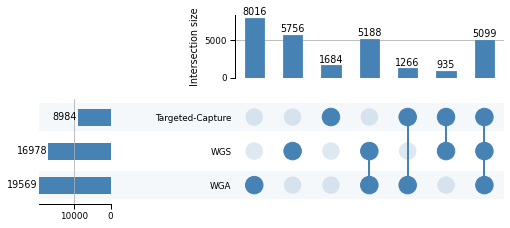

In [20]:
data=pd.merge(variants, samples[["run_accession", "library_strategy"]], left_on="sample", right_on="run_accession")
annotations=[]
table = data.groupby(['variant_id', 'library_strategy']).size().unstack(fill_value=0).astype(bool)
all_afs = data.set_index(['variant_id'])
all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
table = table.reset_index().join(all_afs, how='inner', on=['variant_id'])
table = table.set_index(list(set(data.library_strategy)))

plt.figure(figsize=(20, 8))
upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
colors= ['orange', 'forestgreen', 'indianred']
for a, c in zip(annotations, colors):
        upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
fig = plt.figure(figsize=(300,100))
upset.plot(fig=fig)
fig.savefig(os.path.join(figures_folder, "figure_02_upset.png"))

## Focused geographical and temporal analysis

In [21]:
top_10_countries = list(samples.country.value_counts().head(10).reset_index()["index"])
samples.country.value_counts().head(10).reset_index()

,index,country
0,Switzerland,24336
1,Spain,23466
2,United Kingdom,16863
3,United States,12909
4,India,1682
5,Poland,1316
6,Italy,978
7,Qatar,589
8,Peru,465
9,Brazil,327


<Figure size 1440x576 with 0 Axes>

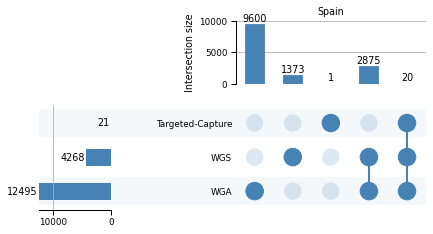

<Figure size 1440x576 with 0 Axes>

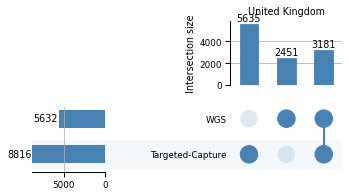

<Figure size 1440x576 with 0 Axes>

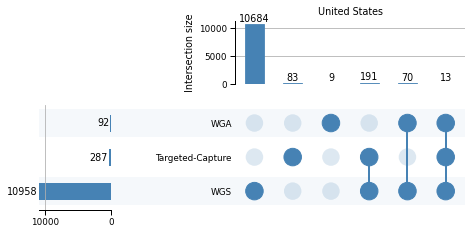

<Figure size 1440x576 with 0 Axes>

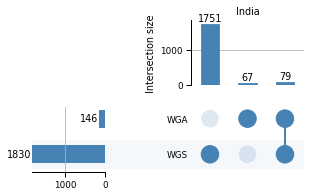

<Figure size 1440x576 with 0 Axes>

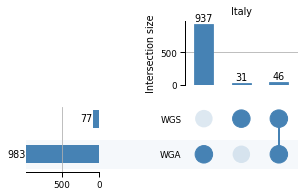

<Figure size 1440x576 with 0 Axes>

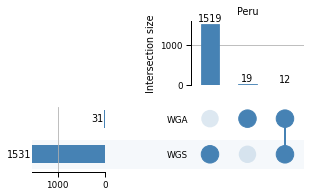

<Figure size 1440x576 with 0 Axes>

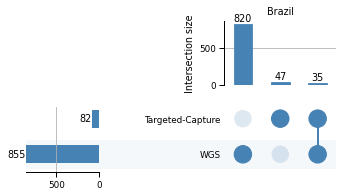

In [22]:
for country in top_10_countries:
    data = pd.merge(variants, samples[["run_accession", "library_strategy", "country"]], left_on="sample", right_on="run_accession")
    data = data[data.country == country]
    if len(data.library_strategy.unique()) > 1:
        annotations=[]
        table = data.groupby(['variant_id', 'library_strategy']).size().unstack(fill_value=0).astype(bool)
        all_afs = data.set_index(['variant_id'])
        all_afs = all_afs.loc[~all_afs.index.duplicated(keep='first')]
        table = table.reset_index().join(all_afs, how='inner', on=['variant_id'])
        table = table.set_index(list(set(data.library_strategy)))

        plt.figure(figsize=(20, 8))
        upset = upsetplot.UpSet(table, subset_size='count', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=50)
        colors= ['orange', 'forestgreen', 'indianred']
        for a, c in zip(annotations, colors):
                upset.add_catplot(value=a, kind='strip', color=c, alpha=0.4)
        fig = plt.figure(figsize=(300,100))
        upset.plot(fig=fig)
        plt.title(country)
        fig.savefig(os.path.join(figures_folder, "figure_03_upset_by_country_{}.png".format(country.replace(" ", "_"))))

## Depth of coverage

The median depth of coverage is of 1171X for WGA, 247X for targeted capture and 132X for WGS.

In [23]:
samples.mean_depth.describe()

count    84125.000000
mean      1249.747954
std       1372.625265
min          0.285323
25%        134.535000
50%       1177.450000
75%       1824.170000
max      26881.700000
Name: mean_depth, dtype: float64

In [24]:
samples.sort_values("library_strategy", inplace=True)

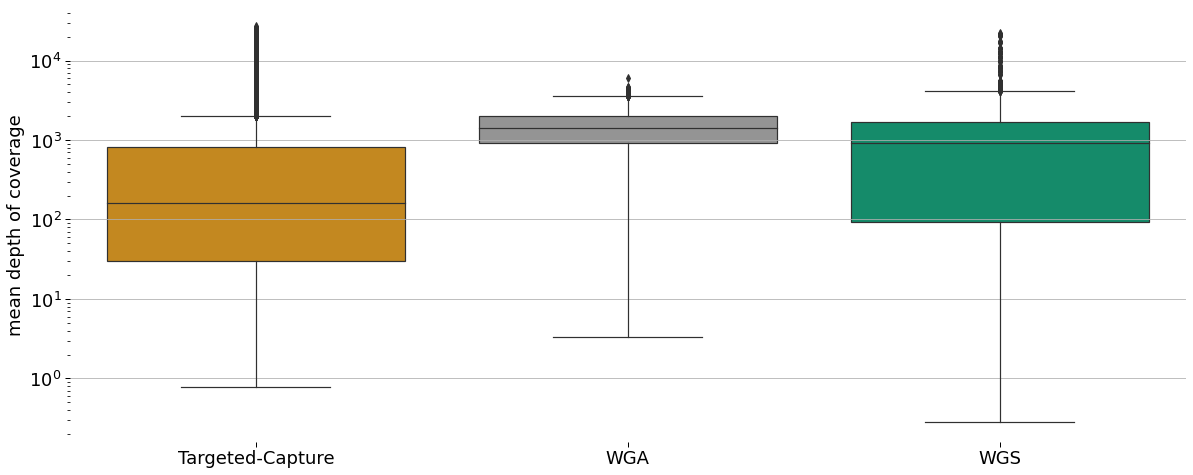

In [25]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=samples, y="mean_depth", x="library_strategy", palette=colors_library_strategy)
plt.title("")
plt.xlabel(None)
plt.ylabel("mean depth of coverage", size=18)
plt.grid(axis="y")
plt.yscale("log")
plt.xticks(fontsize=18)
plt.yticks(size=18)
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_04_width_coverage_boxplot.png"))

In [26]:
samples[samples.library_strategy == "WGA"].mean_depth.describe()

count    45125.000000
mean      1437.022863
std        860.501938
min          3.305990
25%        924.467000
50%       1397.320000
75%       1993.130000
max       5966.820000
Name: mean_depth, dtype: float64

In [27]:
samples[samples.library_strategy == "WGS"].mean_depth.describe()

count    26236.000000
mean      1020.965612
std       1050.262633
min          0.285323
25%         94.280000
50%        915.820000
75%       1696.817500
max      22397.000000
Name: mean_depth, dtype: float64

In [28]:
samples[samples.library_strategy == "Targeted-Capture"].mean_depth.describe()

count    12764.000000
mean      1057.923545
std       2695.338590
min          0.789152
25%         29.817675
50%        161.746000
75%        810.005500
max      26881.700000
Name: mean_depth, dtype: float64

## Breadth of coverage

We found that the library strategy with highest breadth of coverage across all samples was the targeted sequencing with a median of 99.9498, followed by WGS with 99.7492 and WGA with 99.0.

In [29]:
samples.coverage.describe()

count    84125.000000
mean        98.956074
std          4.968990
min         20.084900
25%         99.702400
50%         99.852900
75%         99.943100
max        100.000000
Name: coverage, dtype: float64

In [30]:
# bins coverage with bin size 5 %
samples["coverage_binned"] = pd.cut(samples.coverage, bins=range(0, 101, 5))

In [31]:
num_samples_by_breadth_coverage = samples[["run_accession", "library_strategy", "coverage_binned", "coverage"]].groupby(
    ["library_strategy", "coverage_binned", "coverage"]).count().reset_index()
num_samples_by_breadth_coverage = pd.merge(num_samples_by_breadth_coverage, count_samples_by_library_strategy, on="library_strategy")
num_samples_by_breadth_coverage["sample_normalised"] = num_samples_by_breadth_coverage.run_accession / num_samples_by_breadth_coverage.total_samples
num_samples_by_breadth_coverage.head()

,library_strategy,coverage_binned,coverage,run_accession,total_samples,sample_normalised
0,Targeted-Capture,"(0, 5]",20.0849,0,12764,0.0
1,Targeted-Capture,"(0, 5]",20.6200,0,12764,0.0
2,Targeted-Capture,"(0, 5]",20.7437,0,12764,0.0
3,Targeted-Capture,"(0, 5]",20.9544,0,12764,0.0
4,Targeted-Capture,"(0, 5]",20.9678,0,12764,0.0


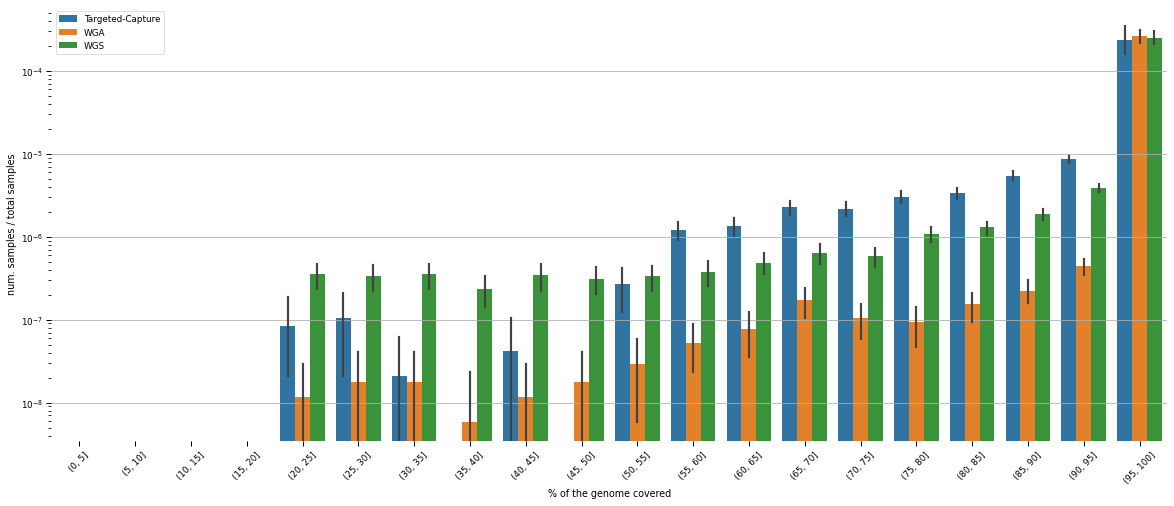

In [32]:
plt.figure(figsize=(20, 8))
sns.barplot(data=num_samples_by_breadth_coverage, 
                x="coverage_binned", y="sample_normalised", hue="library_strategy")
plt.xticks(rotation=45)
plt.title("")
plt.ylabel("num. samples / total samples")
plt.xlabel("% of the genome covered")
plt.legend(title=None)
#plt.grid(axis="x")
plt.grid(axis="y")
plt.yscale("log")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_05_bredth_coverage_per_sample_distribution.png"))

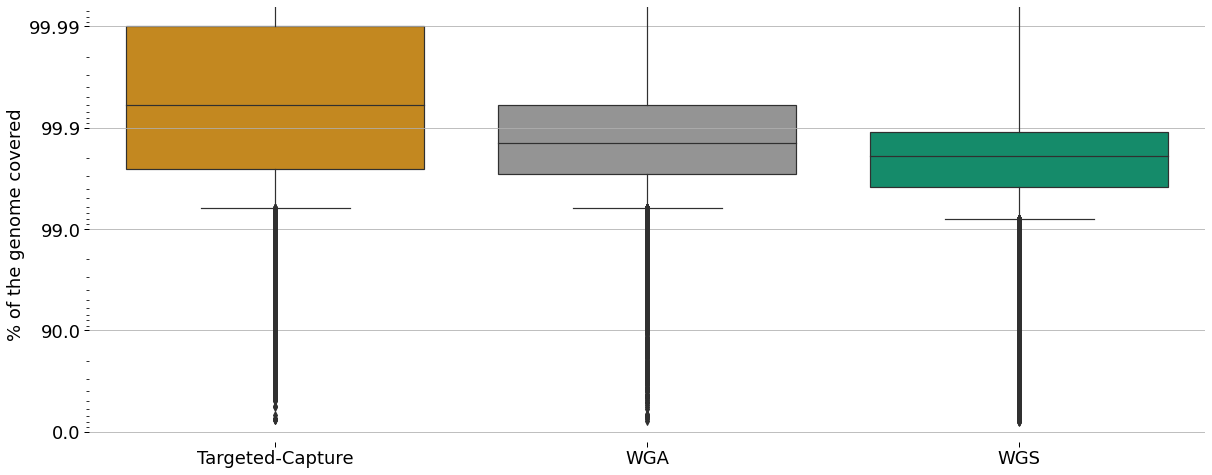

In [33]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=samples, y=100 - samples.coverage, x="library_strategy", palette=colors_library_strategy)
plt.title("")
plt.xlabel(None)
plt.ylabel("% of the genome covered", size=18)
plt.grid(axis="y")
plt.yscale("log")
plt.yticks([0.01, 0.1, 1, 10, 100], ["99.99", "99.9", "99.0", "90.0", "0.0"])
plt.gca().invert_yaxis()
plt.xticks(fontsize=18)
plt.yticks(size=18)
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_05_bredth_coverage_boxplot.png"))

In [34]:
samples[samples.library_strategy == "WGA"].coverage.describe()

count    45125.000000
mean        99.584630
std          2.012123
min         20.967800
25%         99.715700
50%         99.859500
75%         99.939800
max        100.000000
Name: coverage, dtype: float64

In [35]:
samples[samples.library_strategy == "WGS"].coverage.describe()

count    26236.000000
mean        98.453549
std          6.872853
min         20.084900
25%         99.615400
50%         99.809400
75%         99.889600
max        100.000000
Name: coverage, dtype: float64

In [36]:
samples[samples.library_strategy == "Targeted-Capture"].coverage.describe()

count    12764.000000
mean        97.766843
std          6.928399
min         23.001000
25%         99.745800
50%         99.939800
75%         99.990000
max        100.000000
Name: coverage, dtype: float64

## Coverage blind spots

The coverage per position data is stored in the file system. Due to performance reasons we sample 1000 samples from the total to read this coverage data.

The median coverage per position is not homogeneous for any library strategy and it drops at the beginning and end of the genome.

All three library strategies show coverage gaps at the end of the genome below 10X from position 29,855, 29,867 and 29,893 for WGA, WGS and targeted capture respectively.
Only WGA and WGS show coverage gaps below 10X at the beginning of the genome until position 38 and 30 respectively.

There are only two internal coverage gaps; a coverage gap below 20X in WGA samples between 22,340 and 22,523; and below 30X there is a small gap  observed in targeted capture samples between positions 21,766 and 21,768. These two gaps are in the N terminal domain. The second gap corresponds to a deletion with high prevalence 21764:ATACATG>A, although this deletion is 6 bp long and not 3 bp. It was confirmed that this deletion was observed irrespective of the library strategy. The first gap is more concerning as it is 183 bp long and lies within the N-terminal domain. 

In [44]:
depth_coverage_sample = os.path.join(samples[samples.run_accession == 'ERR6360438']['sample_folder'].iloc[0], "ERR6360438.depth.tsv")
sample_depth_coverage = pd.read_csv(depth_coverage_sample, sep="\t", names=["chromosome", "position", "ERR6360438"], skiprows=1)
sample_depth_coverage.head()

,chromosome,position,ERR6360438
0,MN908947.3,32,1
1,MN908947.3,33,1
2,MN908947.3,34,1
3,MN908947.3,35,1
4,MN908947.3,36,1


In [46]:
coverages_list = []
num_samples = 1000
for sample in samples.sample(n=num_samples).run_accession:
    path = os.path.join(samples[samples.run_accession == sample].sample_folder.iloc[0], sample + ".depth.tsv")
    data = pd.read_csv(path, sep="\t", names=["chromosome", "position", "count"], skiprows=1)
    del data["chromosome"]
    data["run_accession"] = sample
    coverages_list.append(data)
coverages = pd.concat(coverages_list)
del coverages_list
coverages = pd.merge(coverages, samples[["run_accession", "library_strategy"]], on="run_accession")

In [47]:
coverages.head()

,position,count,run_accession,library_strategy
0,6,1,SRR17925031,WGS
1,7,1,SRR17925031,WGS
2,8,2,SRR17925031,WGS
3,9,2,SRR17925031,WGS
4,10,4,SRR17925031,WGS


In [48]:
median_coverage_by_position = coverages[["position", "count", "library_strategy"]].groupby(["position", "library_strategy"]).median().reset_index()
median_coverage_by_position.head()

,position,library_strategy,count
0,1,Targeted-Capture,20.0
1,1,WGA,1.0
2,1,WGS,2.5
3,2,Targeted-Capture,21.0
4,2,WGA,1.5


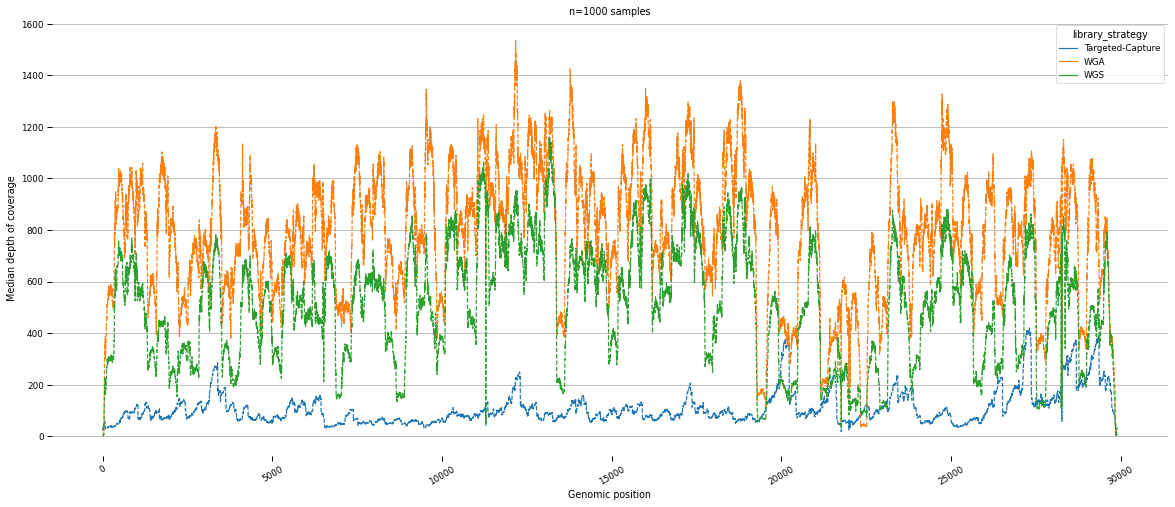

In [49]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position, x="position", y="count", hue="library_strategy", legend=True, linestyle="--")
plt.xticks(rotation=30)
plt.title("n={} samples".format(num_samples))
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_06_coverage_by_position.png"))

In [50]:
def get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 10):

    data = median_coverage_by_position[
        (median_coverage_by_position["count"] < coverage_threshold) & 
        (median_coverage_by_position.library_strategy == library_strategy)]
    data["step"] = data.position - data.position.shift(1)
    return data[data.step != 1] #data[data.step != 1] #data[(data.position > 1000) & (data.position < 28000)] #data[data.step != 1]

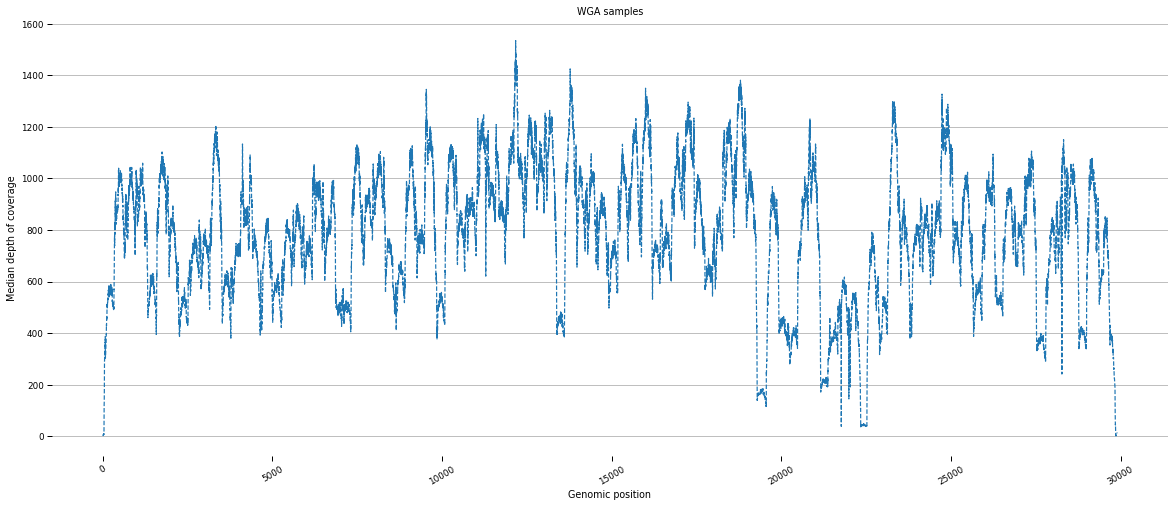

In [51]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "WGA"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("WGA samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_06_coverage_by_position_wga.png"))

In [52]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 10)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
1,1,WGA,1.0,NaN
89563,29855,WGA,9.0,29818.0


In [53]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 20)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
1,1,WGA,1.0,NaN
89560,29854,WGA,12.0,29816.0


In [54]:
get_coverage_gaps(library_strategy = "WGA", coverage_threshold = 30)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
1,1,WGA,1.0,NaN
89554,29852,WGA,25.0,29814.0


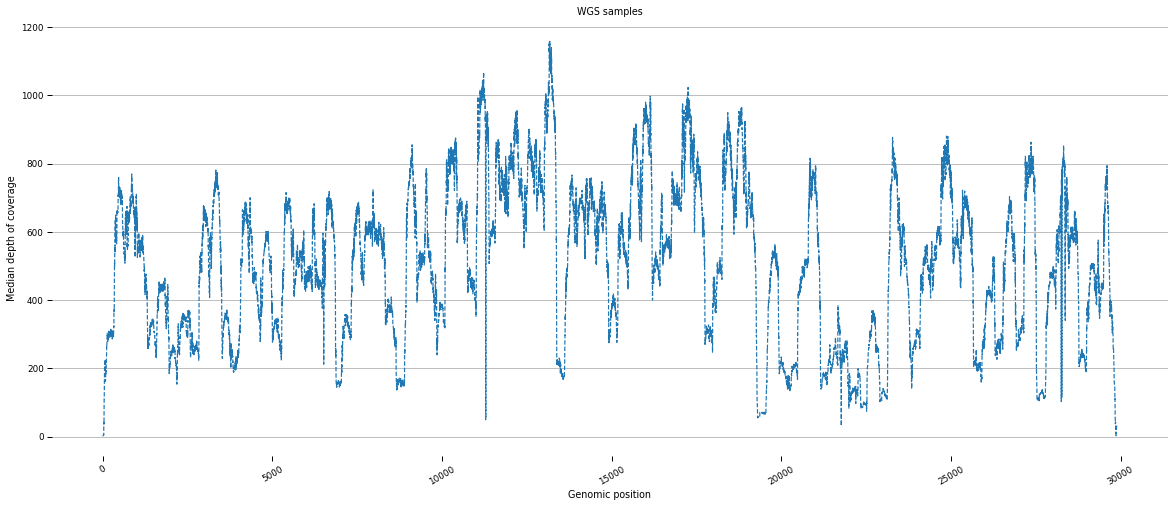

In [55]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "WGS"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("WGS samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_06_coverage_by_position_wgs.png"))

In [56]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 10)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
2,1,WGS,2.5,NaN
89582,29861,WGS,8.5,29831.0
89600,29867,WGS,2.0,5.0


In [57]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 20)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
2,1,WGS,2.5,NaN
89567,29856,WGS,19.0,29826.0


In [58]:
get_coverage_gaps(library_strategy = "WGS", coverage_threshold = 30)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
2,1,WGS,2.5,NaN
89561,29854,WGS,25.0,29824.0
89678,29893,WGS,29.0,6.0


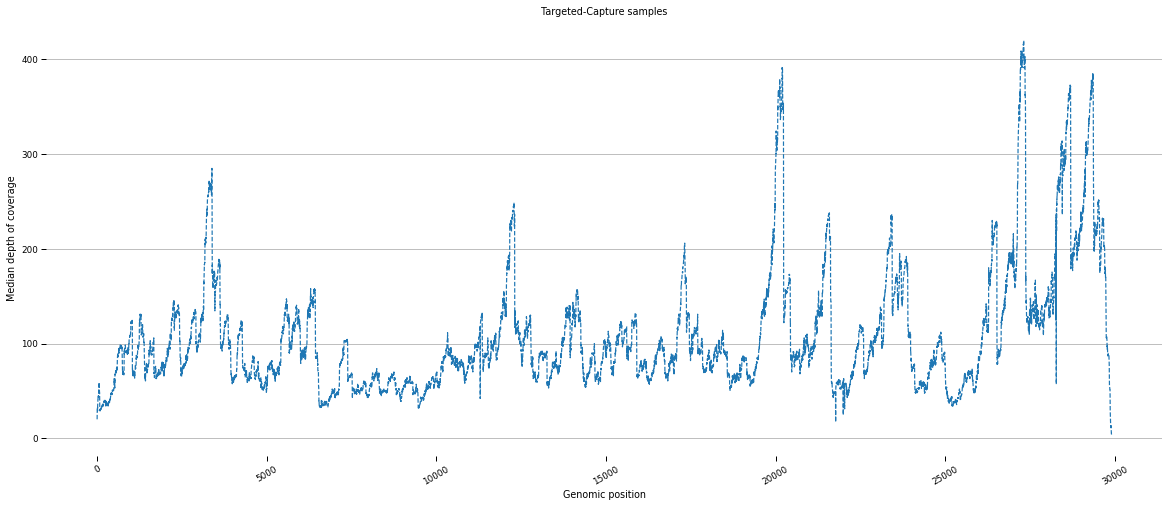

In [59]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=median_coverage_by_position[median_coverage_by_position.library_strategy == "Targeted-Capture"], 
             x="position", y="count", linestyle="--")
plt.xticks(rotation=30)
plt.title("Targeted-Capture samples")
plt.ylabel("Median depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_06_coverage_by_position_targeted_capture.png"))

In [60]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 10)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
89664,29889,Targeted-Capture,9.0,NaN


In [61]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 20)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
65292,21765,Targeted-Capture,19.0,NaN
89595,29866,Targeted-Capture,18.0,8097.0


In [62]:
get_coverage_gaps(library_strategy = "Targeted-Capture", coverage_threshold = 30)

<ipython-input-50-8dc97f95704e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["step"] = data.position - data.position.shift(1)


,position,library_strategy,count,step
0,1,Targeted-Capture,20.0,NaN
42,15,Targeted-Capture,29.0,13.0
234,79,Targeted-Capture,29.0,64.0
65292,21765,Targeted-Capture,19.0,21670.0
65970,21991,Targeted-Capture,25.0,221.0
89580,29861,Targeted-Capture,29.0,7868.0


In [63]:
samples[samples.run_accession.isin(variants[variants.variant_id == "21764:ATACATG>A"]["sample"])].library_strategy.value_counts()

WGA                 11984
WGS                  7737
Targeted-Capture     2240
Name: library_strategy, dtype: int64

In [64]:
max_coverage_by_position = coverages[["position", "count", "library_strategy"]].groupby(["position", "library_strategy"]).max().reset_index()
max_coverage_by_position.head()

,position,library_strategy,count
0,1,Targeted-Capture,1709
1,1,WGA,10
2,1,WGS,25
3,2,Targeted-Capture,1756
4,2,WGA,10


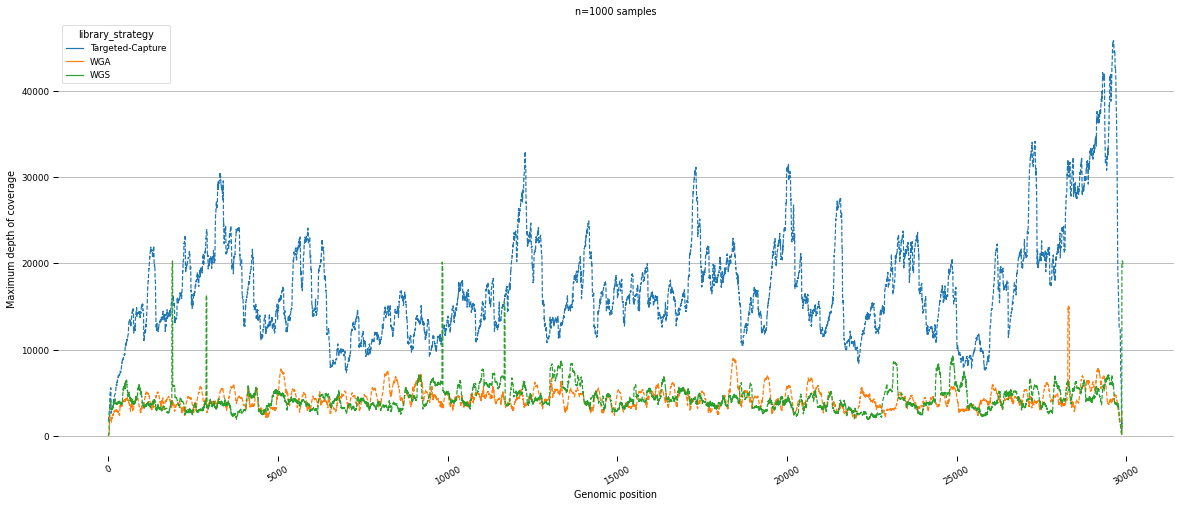

In [65]:
plt.figure(figsize=(20, 8))
sns.lineplot(data=max_coverage_by_position, x="position", y="count", hue="library_strategy", legend=True, linestyle="--")
plt.xticks(rotation=30)
plt.title("n={} samples".format(num_samples))
plt.ylabel("Maximum depth of coverage")
plt.xlabel("Genomic position")
plt.grid(axis="y")
sns.despine(bottom=True, left=True)
plt.savefig(os.path.join(figures_folder, "figure_06_max_coverage_by_position.png"))